In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plot=False

## 1. Creating different impulse responses 

We first create a simple system class that takes in an impulse response specification and tracks the history dose in order to output the current observations.

In [3]:
class system:
    def __init__(self, g=None):
        self.g = g
        self.dose_history = []
        
    def reset(self):
        self.dose_history = []
    
    def step(self, dose, disturbance=0):
        self.dose_history.append(dose)
        np_dose_history = np.array(self.dose_history, copy=True)
        return np.dot(self.g[:len(self.dose_history)], np.flip(np_dose_history)) + disturbance
    
    def get_obs(self, disturbance=0):
        np_dose_history = np.array(self.dose_history, copy=True)
        return np.dot(self.g[:len(self.dose_history)], np.flip(np_dose_history)) + disturbance
    
    def initialize_addiction(self, dose_history):
        self.dose_history = dose_history.copy()
        
    def initialize_and_plot_addiction(self, dose_history):
        obs_hist = []
        self.reset()
        for t in range(len(dose_history)):
            self.dose_history.append(dose_history[t])
            np_dose_history = np.array(self.dose_history, copy=True)
            obs_hist.append(np.dot(self.g[:len(self.dose_history)], np_dose_history))
        plt.plot(obs_hist)
        plt.title('Effect Deterioration')
    
    def plot_impulse(self, T=30):
        plt.title('Impulse Response')
        plt.plot(self.g[:T]);

We create a simple function that converts a linear system to an impulse response of the above form:

In [4]:
def create_linear_impulse(A, b, c, T):
    return [np.dot(c, b)] + [np.dot(c, np.power(A, p) @ b) for p in range(1, T)]

### 1.a. Creation & Vizualization of Impulse Responses

First let us look at a very simple linear models that aims to capture the effects of an abstract stimulant over time. The A process would correspond to released (& bonded) dopamine, while the B process would correspond to slow increases in the dopamine receptors (leading to increased reuptake). A timestep is one day. We have two systems below, one for hard drugs, and one for more medication type drugs.

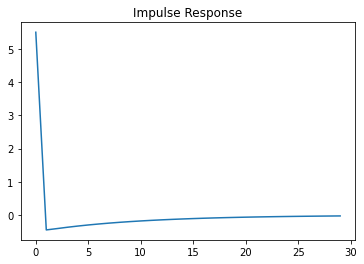

In [5]:
med_lin_sys = system(create_linear_impulse(np.array([[0.001, 0], [0, 0.9]], dtype=object),
                                    np.array([6, 0.5]), np.array([1, -1]), 180))
if plot: med_lin_sys.plot_impulse()

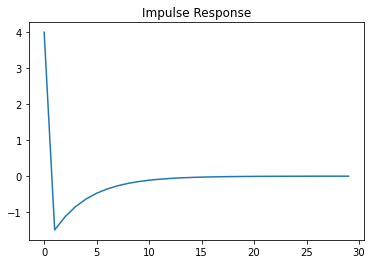

In [6]:
hrd_lin_sys = system(create_linear_impulse(np.array([[0.001, 0], [0, 0.75]], dtype=object),
                                np.array([6, 2]), np.array([1, -1]), 180))
if plot: hrd_lin_sys.plot_impulse()

### 1.b. Creation & Vizualization of effect deterioration/addiction

In order to study the different protocols, we first need to start off in an 'addicted' state of the system. We vizualize this below, where we assume addiction happened due to taking 1 unit of dose every day for 30 days:

In [7]:
addict_T = 90
addict_dose = 1
addict_dose_history = list(addict_dose * np.ones(addict_T))

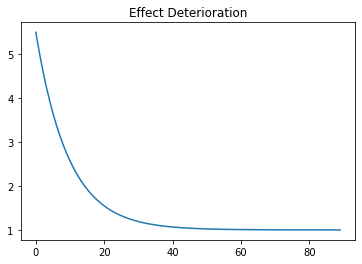

In [8]:
if plot: med_lin_sys.initialize_and_plot_addiction(addict_dose_history)

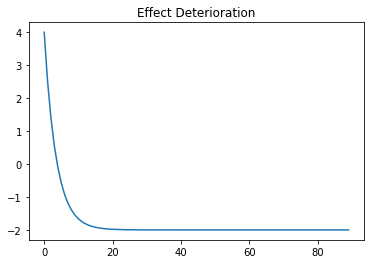

In [9]:
if plot: hrd_lin_sys.initialize_and_plot_addiction(addict_dose_history)

## 2. Creating and testing different tapering protocols

We first create the necessary classes and functions to use later.

In [10]:
def cold_turkey(obs, disturbance=0):
    return 0

In [11]:
class on_off:
    def __init__(self, init_dose, obs_min):
        self.obs_min = obs_min
        self.init_dose = init_dose
    
    def __call__(self, obs, disturbance=0):
        return self.init_dose if obs < self.obs_min else 0

In [12]:
class linear:
    def __init__(self, init_dose, rate):
        self.init_dose = init_dose
        self.last_dose = init_dose
        self.rate = rate
        
    def __call__(self, obs, disturbance=0):
        self.last_dose = max(0, self.last_dose - self.rate * self.init_dose)
        return self.last_dose
    
    def reset(self):
        self.last_dose = self.init_dose

In [13]:
class exp:
    def __init__(self, init_dose, rate):
        self.init_dose = init_dose
        self.last_dose = init_dose
        self.rate = rate
        
    def __call__(self, obs, disturbance = 0):
        self.last_dose = self.rate * self.last_dose
        return self.last_dose
    
    def reset(self):
        self.last_dose = self.init_dose

In [14]:
class clairvoyant:
    def __init__(self, init_dose, obs_min, g, dose_history):
        self.obs_min = obs_min
        self.g = g
        self.dose_history = dose_history.copy()
    
    def __call__(self, obs, disturbance = 0):
        np_dose_history = np.array(self.dose_history, copy=True)
        dose = max(0, (obs_min - np.dot(self.g[1:len(self.dose_history)+1], np.flip(np_dose_history)))/self.g[0])
        self.dose_history.append(dose)
        return dose 

In [15]:
class optimal:
    def __init__(self, init_dose, obs_min, g, L=0):
        self.obs_min = obs_min
        self.last_dose = init_dose
        self.g = g
        self.L = L
        self.dose_diff_history = [init_dose]
    
    def __call__(self, obs, disturbance = 0):
        np_dose_diff_history = np.array(self.dose_diff_history, copy=True)
        dose_diff_component = np.dot(self.g[1:len(self.dose_diff_history)+1], np.flip(np_dose_diff_history)) \
                            if len(self.dose_diff_history) > 0 else 0
        new_dose = max(0, self.last_dose - (obs - self.obs_min - self.L - dose_diff_component)/self.g[0])
        self.dose_diff_history.append(new_dose - self.last_dose)
        self.last_dose = new_dose
        
        return self.last_dose

In [16]:
class lookahead:
    def __init__(self, init_dose, obs_min, g0, L=0, monotone=True):
        self.obs_min = obs_min
        self.init_dose = init_dose
        self.last_dose = init_dose
        self.g0 = g0
        self.L = L
        self.monotone = monotone
        
    def __call__(self, obs, disturbance = 0):
        dose = max(0, self.last_dose - (obs - self.obs_min - self.L)/self.g0)
        self.last_dose = min(self.last_dose, dose) if self.monotone else dose
        
        return self.last_dose
    
    def reset(self):
        self.last_dose = self.init_dose

### 2.a. Vizualizing the different protocols under no noise

In [17]:
def zero():
    return 0

In [18]:
def test(system, protocol, T, noise_generator=zero):
    obs_hist = [system.get_obs()]
    dose_hist = []
    disturbance = 0
    for t in range(T):
        dose = protocol(obs_hist[-1], disturbance)
        disturbance = noise_generator()
        obs_hist.append(system.step(dose, disturbance))
        dose_hist.append(dose)
    return obs_hist[:T-1], dose_hist
        
def test_and_plot(system, protocol, T, noise_generator=zero):
    obs_hist = [system.get_obs()]
    dose_hist = []
    for t in range(T):
        dose = protocol(obs_hist[-1])
        obs_hist.append(system.step(dose, noise_generator()))
        dose_hist.append(dose)
    plt.plot(obs_hist[:T-1], label="obs")
    plt.plot(dose_hist, label = "dose")
    plt.legend()
    try:
        plt.title(protocol.__name__ + " withdrawal");
    except:
        plt.title(protocol.__class__.__name__ + " withdrawal");

In [19]:
addict_T = 30
addict_dose = 1
addict_dose_history = list(addict_dose * np.ones(addict_T))

taper_T = 30

In [20]:
drug = 'A'

In [21]:
if drug == 'A':
    test_system = med_lin_sys
elif drug == 'B':
    test_system = hrd_lin_sys

1. We first vizualize the cold turkey withdrawal.

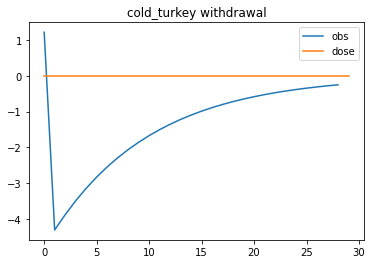

In [22]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, cold_turkey, taper_T)

2. Now let's vizualize what happens if we decrease the dose by some rate at every timestep:

In [23]:
lin_rate = 0.1

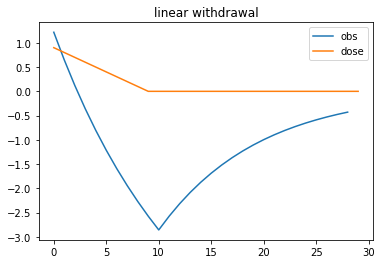

In [24]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, linear(addict_dose, lin_rate), taper_T)

3. Let's finally see the exponential protocol

In [25]:
exp_rate = 0.9

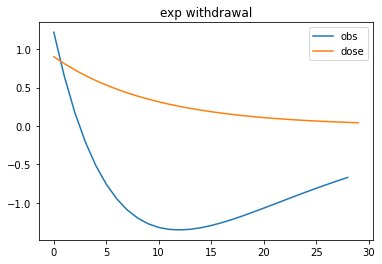

In [26]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, exp(addict_dose, exp_rate), taper_T)

4. Now we will look at the optimal protocol with or without history. For now assume we do not know the Lipschitz ct. L

In [27]:
obs_min = 0

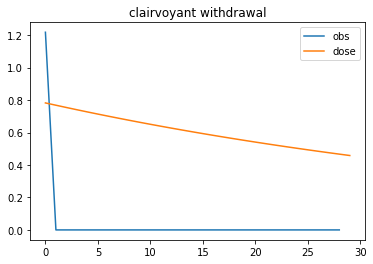

In [28]:
# with full history
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, clairvoyant(addict_dose, obs_min, test_system.g, addict_dose_history), taper_T)

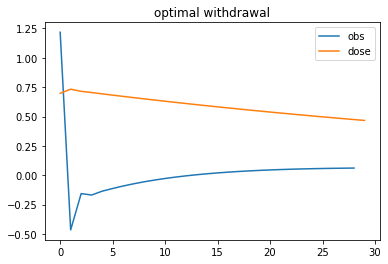

In [29]:
# without full history
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, optimal(addict_dose, obs_min, test_system.g), taper_T)

In [30]:
# with Lipschitz ct.
L = 0.5

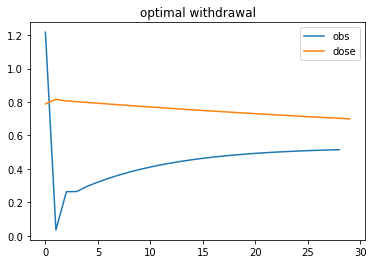

In [31]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, optimal(addict_dose, obs_min, test_system.g, L=L), taper_T)

5. Finally let's look at lookahead first with correct g0:

In [32]:
obs_min = 0

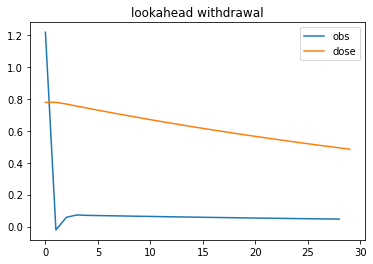

In [33]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, lookahead(addict_dose, obs_min, test_system.g[0]), taper_T)

Now let's consider being wrong by a bit and having some L estimate.

In [36]:
eps_g = test_system.g[0]/10
g0_cons = test_system.g[0] + eps_g
L = 0.5
obs_min = 0

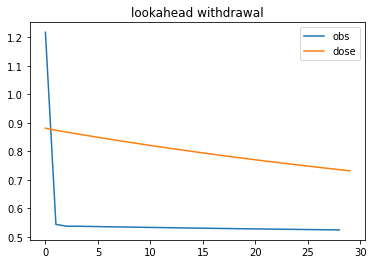

In [37]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, lookahead(addict_dose, obs_min, g0_cons, L=L), taper_T)

### 2b. Creating & Vizualizing with Noise Generator

In [38]:
class uniform:
    def __init__(self, low, high):
        self.low = low
        self.high = high
    def __call__(self):
        return np.random.uniform(self.low, self.high)
    
class uniform_poisson:
    def __init__(self, low, high, lam):
        self.low = low
        self.high = high
        self.lam = lam
    def __call__(self):
        return np.random.poisson(self.lam) * np.random.uniform(self.low, self.high)

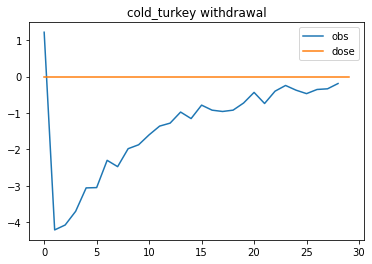

In [39]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, cold_turkey, taper_T, noise_generator=uniform(-0.25,0.25))

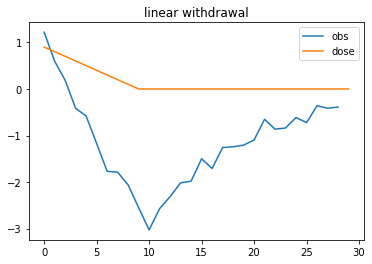

In [40]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, linear(addict_dose, lin_rate), taper_T, noise_generator=uniform(-0.25,0.25))

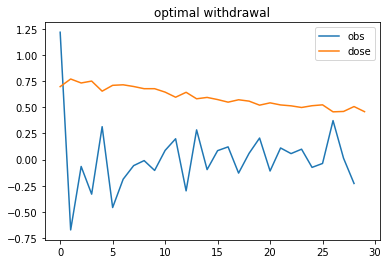

In [41]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, optimal(addict_dose, obs_min, test_system.g), taper_T, noise_generator=uniform(-0.25,0.25))

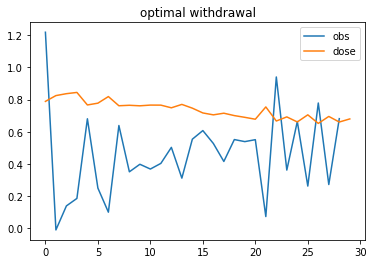

In [42]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, optimal(addict_dose, obs_min, test_system.g, L=L), taper_T, noise_generator=uniform(-0.25,0.25))

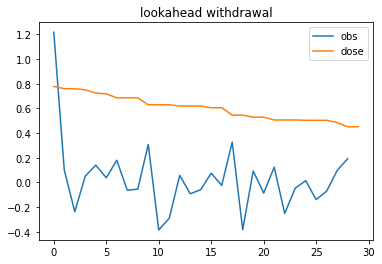

In [43]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, lookahead(addict_dose, obs_min, test_system.g[0]), taper_T, noise_generator=uniform(-0.25,0.25))

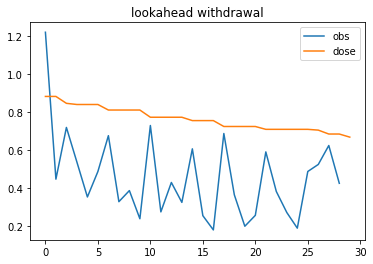

In [44]:
test_system.initialize_addiction(addict_dose_history)
if plot: test_and_plot(test_system, lookahead(addict_dose, obs_min, g0_cons, L=L, monotone=True), taper_T, noise_generator=uniform(-0.25,0.25))

## 3. Comparison on Population

Now we finally test on a population on patients and create a scatter plot of the performances of different protocols. First let's consider the situation where all units have the same underlying dose response (Drug A), and experience some uniform noise on each measurement and each unit has a desired obs_min drawn uniformly from (-1,1).

In [45]:
def test_population(trials, system, noise_generator, obs_min_generator, protocol, taper_T):
    violation = []
    subopt = []
    
    for trial in range(trials):
        # generate same obs_min
        np.random.seed(trial)
        obs_min = obs_min_generator()
        try: # lookahead takes true obs_min
            protocol.obs_min = obs_min
        except: # others don't
            pass
        
        # initialize addiction and reset noise generator
        system.initialize_addiction(addict_dose_history), np.random.seed(trial)
        _, clairvoyant_doses = test(system, clairvoyant(addict_dose, obs_min, system.g, \
                                    addict_dose_history), taper_T, noise_generator=noise_generator)
        
        # initialize addiction and reset noise generator
        system.initialize_addiction(addict_dose_history), np.random.seed(trial)    
        
        try: # need to reset protocols per each rial
            protocol.reset()
        except: # no need to reset cold turkey
            pass
        
        obs, doses = test(system, protocol, taper_T, noise_generator=noise_generator)

        # extract experiment metrics
        violation.append(np.sum(np.maximum((obs_min * np.ones(taper_T-1) - obs), 0)))
        subopt.append(np.sum(np.maximum((np.array(doses) - np.array(clairvoyant_doses)), 0)))
    
    return np.mean(violation), np.std(violation), np.mean(subopt), np.std(subopt)

In [46]:
trials = 100
noise_lb, noise_ub = (-0.25, 0.25)
taper_T = 30
obs_min_lb, obs_min_ub = -1, 1
test_system=med_lin_sys

In [47]:
viol_mean = {}
viol_std = {}
subopt_mean = {}
subopt_std = {}

In [48]:
viol_mean['ct'], viol_std['ct'], \
subopt_mean['ct'], subopt_std['ct'] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=cold_turkey, taper_T=taper_T)

In [49]:
if plot:
    print("cold turkey cumulative constraint violation mean:", viol_mean['ct'], "std:", viol_std['ct'])
    print("cold turkey dose subopt mean:", subopt_mean['ct'], "std:", subopt_std['ct'])

cold turkey cumulative constraint violation mean: 40.529981728307234 std: 14.771279737192472
cold turkey dose subopt mean: 0.0 std: 0.0


In [50]:
lin_rates = {}
lin_rates['A'] = [0.01, 0.02, 0.03, 0.04, 0.06, 0.1]
lin_rates['B'] = [0.05, 0.1, 0.15, 0.2, 0.25]

for lin_rate in lin_rates[drug]:
    viol_mean['lin-'+str(lin_rate)], viol_std['lin-'+str(lin_rate)], \
    subopt_mean['lin-'+str(lin_rate)], subopt_std['lin-'+str(lin_rate)] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=linear(addict_dose, lin_rate), taper_T=taper_T)
    
    if plot:
        print(str(lin_rate) + " cc violation mean:", viol_mean['lin-'+str(lin_rate)], "std:", viol_std['lin-'+str(lin_rate)])
        print(str(lin_rate) + " dose subopt mean:", subopt_mean['lin-'+str(lin_rate)], "std:", subopt_std['lin-'+str(lin_rate)])

0.01 cc violation mean: 1.461471228635504 std: 2.762749654573872
0.01 dose subopt mean: 7.151006230599633 std: 2.6645352591003757e-15
0.02 cc violation mean: 5.9166195477914405 std: 7.263787925007336
0.02 dose subopt mean: 2.6828420525663783 std: 1.3322676295501878e-15
0.03 cc violation mean: 13.789756190956211 std: 10.908823912642962
0.03 dose subopt mean: 1.1575280500078367 std: 4.440892098500626e-16
0.04 cc violation mean: 23.160719291949803 std: 12.698751603955351
0.04 dose subopt mean: 0.6932669456569843 std: 1.1102230246251565e-16
0.06 cc violation mean: 30.436965608620653 std: 14.027533186576429
0.06 dose subopt mean: 0.35452836131063736 std: 0.0
0.1 cc violation mean: 34.89417916965711 std: 14.627431505411089
0.1 dose subopt mean: 0.14928510693747613 std: 2.7755575615628914e-17


In [51]:
exp_rates = {}
exp_rates['A'] = [0.8, 0.9, 0.95, 0.97, 0.98, 0.99]
exp_rates['B'] = [0.5, 0.6, 0.7, 0.9, 0.95]

for exp_rate in exp_rates[drug]:
    viol_mean['exp-'+str(exp_rate)], viol_std['exp-'+str(exp_rate)], \
    subopt_mean['exp-'+str(exp_rate)], subopt_std['exp-'+str(exp_rate)] = test_population(trials, system=test_system, \
                                                    noise_generator=uniform(noise_lb, noise_ub), \
                                                    obs_min_generator=uniform(obs_min_lb, obs_min_ub),
                                                    protocol=exp(addict_dose, exp_rate), taper_T=taper_T)
    
    if plot:
        print(str(exp_rate) + " cc violation mean:", viol_mean['exp-'+str(exp_rate)], "std:", viol_std['exp-'+str(exp_rate)])
        print(str(exp_rate) + " dose subopt mean:", subopt_mean['exp-'+str(exp_rate)], "std:", subopt_std['exp-'+str(exp_rate)])

0.8 cc violation mean: 34.3088825761174 std: 15.253209590968584
0.8 dose subopt mean: 0.01759385786263257 std: 3.469446951953614e-18
0.9 cc violation mean: 25.780614736800803 std: 14.750103649591287
0.9 dose subopt mean: 0.1592851069374761 std: 0.0
0.95 cc violation mean: 13.614881943781144 std: 12.146300517458805
0.95 dose subopt mean: 0.5471531703532769 std: 1.1102230246251565e-16
0.97 cc violation mean: 6.95135690871569 std: 8.414683305758514
0.97 dose subopt mean: 1.5481077090862307 std: 0.0
0.98 cc violation mean: 3.759995865424092 std: 5.603114897996155
0.98 dose subopt mean: 4.072274580860211 std: 0.0
0.99 cc violation mean: 1.1548544232703413 std: 2.3396331054469965
0.99 dose subopt mean: 7.570669265159868 std: 3.552713678800501e-15


In [52]:
g0_fracs = {}
g0_fracs['A'] = [0, 0.25, 0.5, 1]
g0_fracs['B'] = [0, 0.1, 0.2, 0.5]

Ls = {}
Ls['A'] = [0.0, 0.2, 0.4, 0.6]
Ls['B'] = [0.0, 0.1, 0.2, 0.3]

for g0_frac in g0_fracs[drug]:
    g0_cons = (1+g0_frac)*test_system.g[0]
    
    for L in Ls[drug]:
        
        viol_mean['lk-'+str(g0_frac)+'-'+str(L)], viol_std['lk-'+str(g0_frac)+'-'+str(L)], \
        subopt_mean['lk-'+str(g0_frac)+'-'+str(L)], subopt_std['lk-'+str(g0_frac)+'-'+str(L)] = \
        \
                test_population(trials, system=test_system, noise_generator=uniform(noise_lb, noise_ub), \
                                obs_min_generator=uniform(obs_min_lb, obs_min_ub), \
                                protocol=lookahead(addict_dose, 0, g0_cons, L=L), taper_T=taper_T)
        
        if plot:
            print(str(g0_frac) + "-" + str(L) + " cc violation mean:", viol_mean['lk-'+str(g0_frac)+'-'+str(L)], "std:", viol_std['lk-'+str(g0_frac)+'-'+str(L)])
            print(str(g0_frac) + "-" + str(L) + " dose subopt mean:", subopt_mean['lk-'+str(g0_frac)+'-'+str(L)], "std:", subopt_std['lk-'+str(g0_frac)+'-'+str(L)])

0-0.0 cc violation mean: 2.3134954784498807 std: 1.0299341030525642
0-0.0 dose subopt mean: 2.1164210151734606 std: 2.9397819829514127
0-0.2 cc violation mean: 0.5326940921594342 std: 0.5062412354124083
0-0.2 dose subopt mean: 3.061562799590681 std: 3.6085437723510356
0-0.4 cc violation mean: 0.05975500576058142 std: 0.18914566926023288
0-0.4 dose subopt mean: 4.105541038748536 std: 4.164222753930448
0-0.6 cc violation mean: 0.027707553852691903 std: 0.1305257294545358
0-0.6 dose subopt mean: 5.267570163240732 std: 4.467034513052588
0.25-0.0 cc violation mean: 1.8058216234778457 std: 1.1049433739691048
0.25-0.0 dose subopt mean: 2.2705920152544476 std: 3.0268657220317325
0.25-0.2 cc violation mean: 0.3942537710781104 std: 0.4738344149248616
0.25-0.2 dose subopt mean: 3.2293779374196254 std: 3.672984838791117
0.25-0.4 cc violation mean: 0.049045044147596056 std: 0.17444857184078136
0.25-0.4 dose subopt mean: 4.286336590055964 std: 4.1859807695605165
0.25-0.6 cc violation mean: 0.0277075